First, let's import all the neccesary packages

In [1]:
import os 
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import torch
import numpy as np
from hydra import compose, initialize
from omegaconf import DictConfig, OmegaConf
from torch_geometric.data import Data
from train import Trainer

/home/ubuntu/miniforge3/envs/JHL_env/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/ubuntu/miniforge3/envs/JHL_env/lib/python3.11/site-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/ubuntu/miniforge3/envs/JHL_env/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/ubuntu/miniforge3/envs/JHL_env/lib/python3.11/site-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


We can then set up the basics

In [2]:
#device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu") # change GPU depending on the run

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Hydra 초기화 및 구성 로드
initialize(config_path="config", version_base="1.1")
cfg = compose(config_name="config.yaml")

# 구성 확인
print(OmegaConf.to_yaml(cfg))

experiment:
  seed: 36
  device: cuda:2
  wandb: false
  wandb_api_key: 899079d77b6e3f0774afe79065ae85b86ac909d2
  wandb_project_name: baseline_EGNN
dataset:
  data_dir: /data/SimJEB/
  max_epochs: 1000
  train_sample_id:
  - 21
  - 30
  - 38
  - 62
  - 8
  - 9
  - 15
  - 23
  - 6
  - 10
  - 22
  - 63
  - 14
  - 29
  - 35
  - 40
  - 19
  - 27
  - 28
  - 33
  valid_sample_id:
  - 20
  - 4
  - 0
  - 12
  - 16
arch:
  encoder:
    input_dim: 2
  processor:
    hidden_dim: 32
    n_layers_proc: 20
  decoder:
    output_dim: 1
scheduler:
  initial_lr: 5.0e-06
  weight_decay: 0.0



The next code block is for testing the encoder and the decoder that turns the graph data into PGA multivector data

In [3]:
trainer = Trainer(cfg, shuffle=False)

# Let's first test a very simple graph and see how it handles it

x = torch.tensor([
        [1,2,3,   4,5,6,   7,8,9],
        [9,8,7,   6,5,4,   3,2,1],
        [10,10,10,2,3,4,   4,5,6]
    ], dtype=torch.float)

bc = torch.tensor([
        [0,0],
        [1,0],
        [0,1]
    ], dtype=torch.float)

y = torch.tensor([
        [0.2],
        [0.4],
        [0.1]
    ], dtype=torch.float)

edge_index = torch.tensor([
        [0, 0],
        [1, 2]
    ], dtype=torch.long)

force = torch.tensor([
    [1,2,1],
    [1,2,1],
    [1,2,1]
])
# bc = torch.cat([force, bc], dim = -1)

graph = Data(x=x, bc=bc, y= y, edge_index=edge_index)
graph = graph.to(trainer.device)


[train] sample_idx: 21 | shape of input: torch.Size([36544, 9]) | shape of bc: torch.Size([36544, 2])
[train] sample_idx: 30 | shape of input: torch.Size([21906, 9]) | shape of bc: torch.Size([21906, 2])
[train] sample_idx: 38 | shape of input: torch.Size([58270, 9]) | shape of bc: torch.Size([58270, 2])
[train] sample_idx: 62 | shape of input: torch.Size([28832, 9]) | shape of bc: torch.Size([28832, 2])
[train] sample_idx:  8 | shape of input: torch.Size([60068, 9]) | shape of bc: torch.Size([60068, 2])
[train] sample_idx:  9 | shape of input: torch.Size([97030, 9]) | shape of bc: torch.Size([97030, 2])
[train] sample_idx: 15 | shape of input: torch.Size([46732, 9]) | shape of bc: torch.Size([46732, 2])
[train] sample_idx: 23 | shape of input: torch.Size([43350, 9]) | shape of bc: torch.Size([43350, 2])
[train] sample_idx:  6 | shape of input: torch.Size([68746, 9]) | shape of bc: torch.Size([68746, 2])
[train] sample_idx: 10 | shape of input: torch.Size([86471, 9]) | shape of bc: tor

Let's then test the forward pass of the GATr network

In [4]:
trainer.make_model_components(cfg)
# trainer.model.to(trainer.device)

with torch.no_grad():
    output = trainer.model(graph)
    print("Output: ", output)
    # print("Output features (x):", output.x)
    # print("Output boundary condition:", output.bc)

Output:  tensor([[-0.1221],
        [ 2.0520],
        [ 4.7162]], device='cuda:2')


Let's now test the ability to do forward pass with our dataset

In [5]:

with torch.no_grad():
    for graph in trainer.valid_loader:
        graph = graph.to(trainer.device)
        output = trainer.model(graph)
        print("Output dimension", output.shape)
        # print("Output graph dimension:", output.x.shape)
        # print("Output bc dimension", output.bc.shape)

Output dimension torch.Size([57168, 1])
Output dimension torch.Size([87908, 1])
Output dimension torch.Size([112873, 1])
Output dimension torch.Size([123939, 1])
Output dimension torch.Size([62273, 1])


In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities = [ProfilerActivity.CUDA], record_shapes = True) as prof:
    with record_function("model_inference"):
        for graph in trainer.valid_loader:
            graph = graph.to(trainer.device)
            output = trainer.model(graph)
            
print(prof.key_averages().table)

Let's now test the learned model

(57168, 1)
(57168, 1)


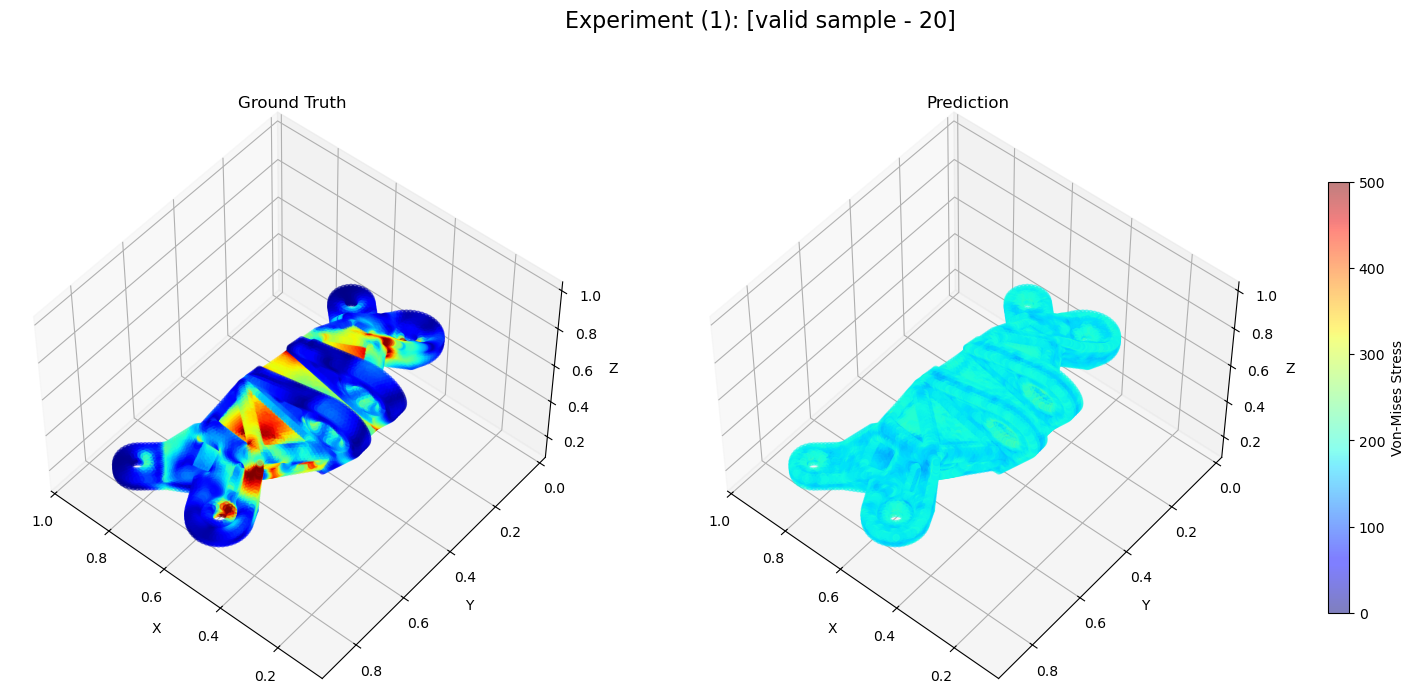

(87908, 1)
(87908, 1)


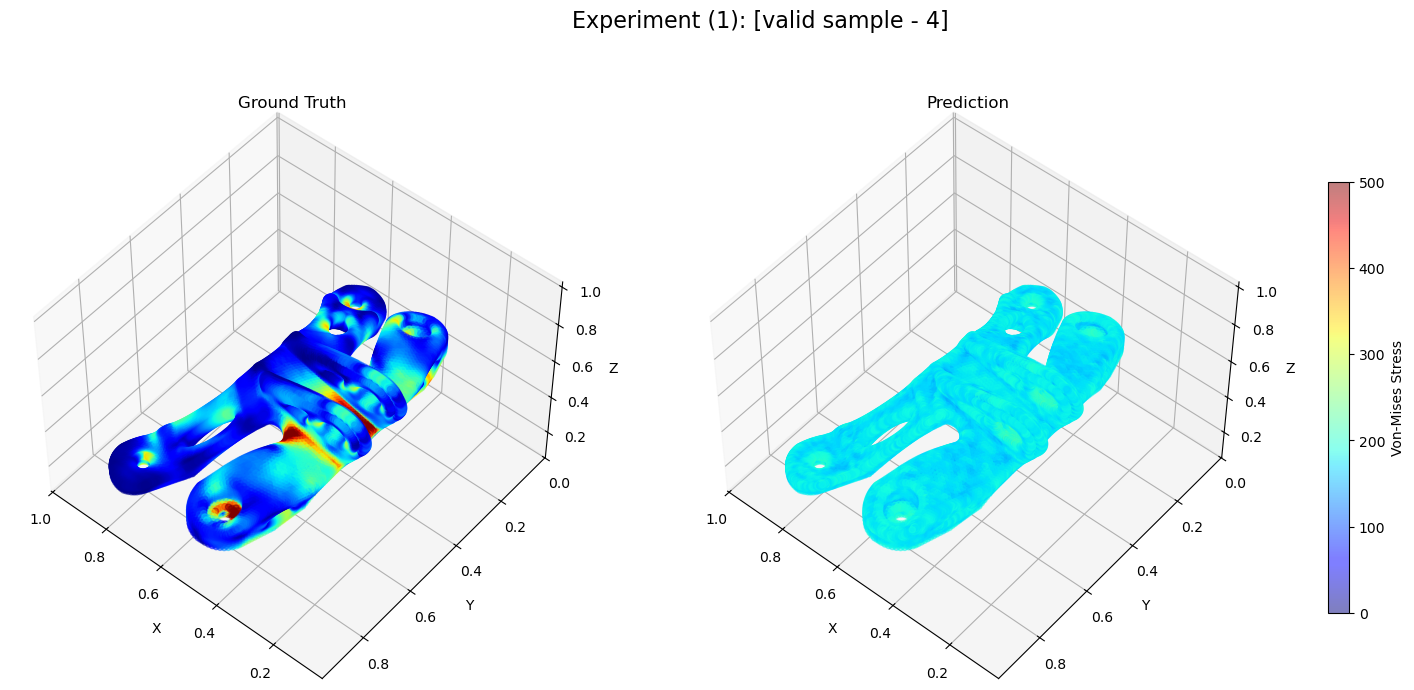

(112873, 1)
(112873, 1)


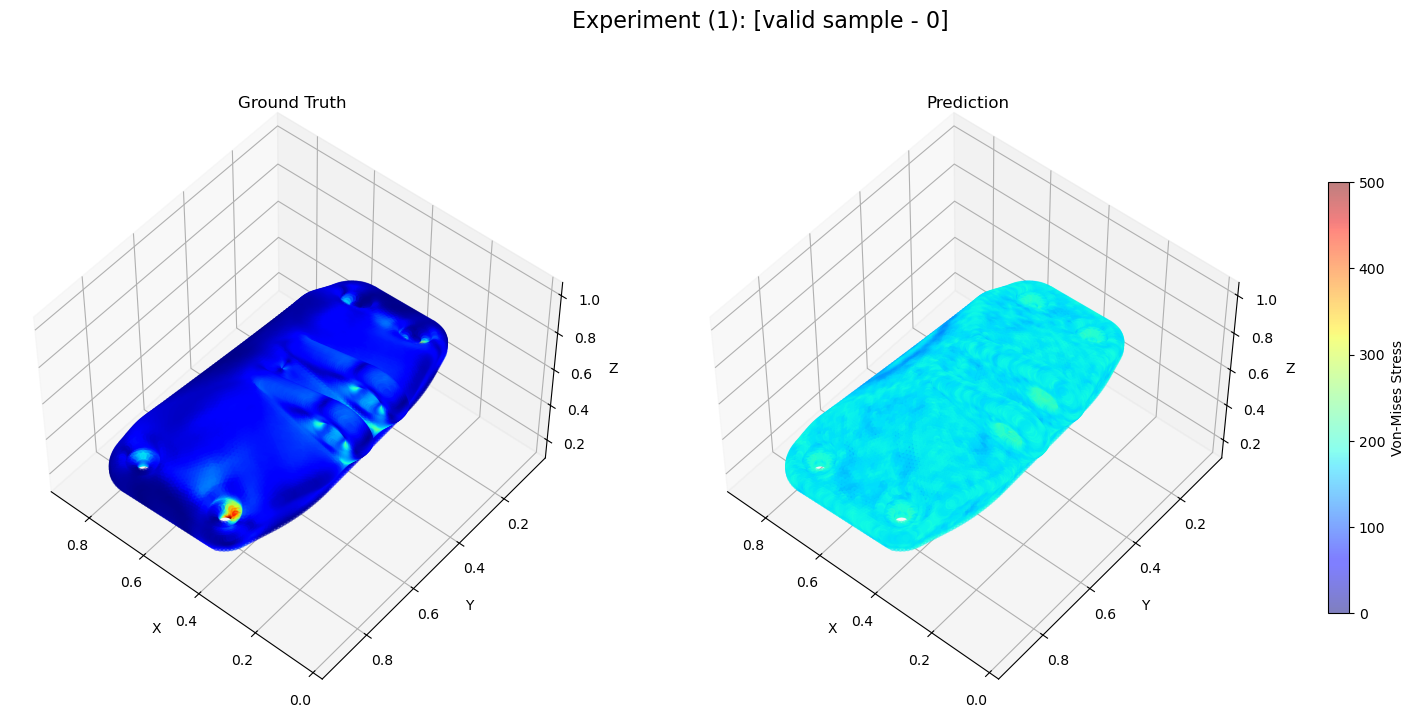

(123939, 1)
(123939, 1)


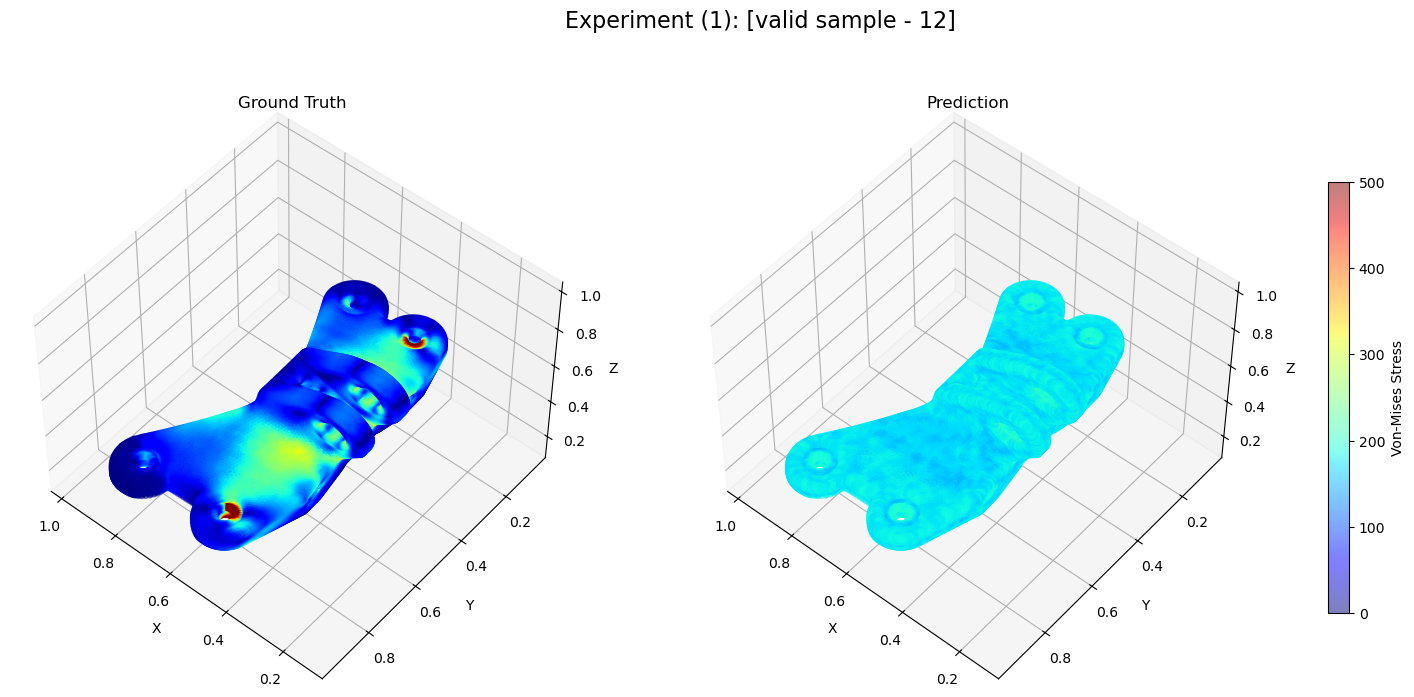

(62273, 1)
(62273, 1)


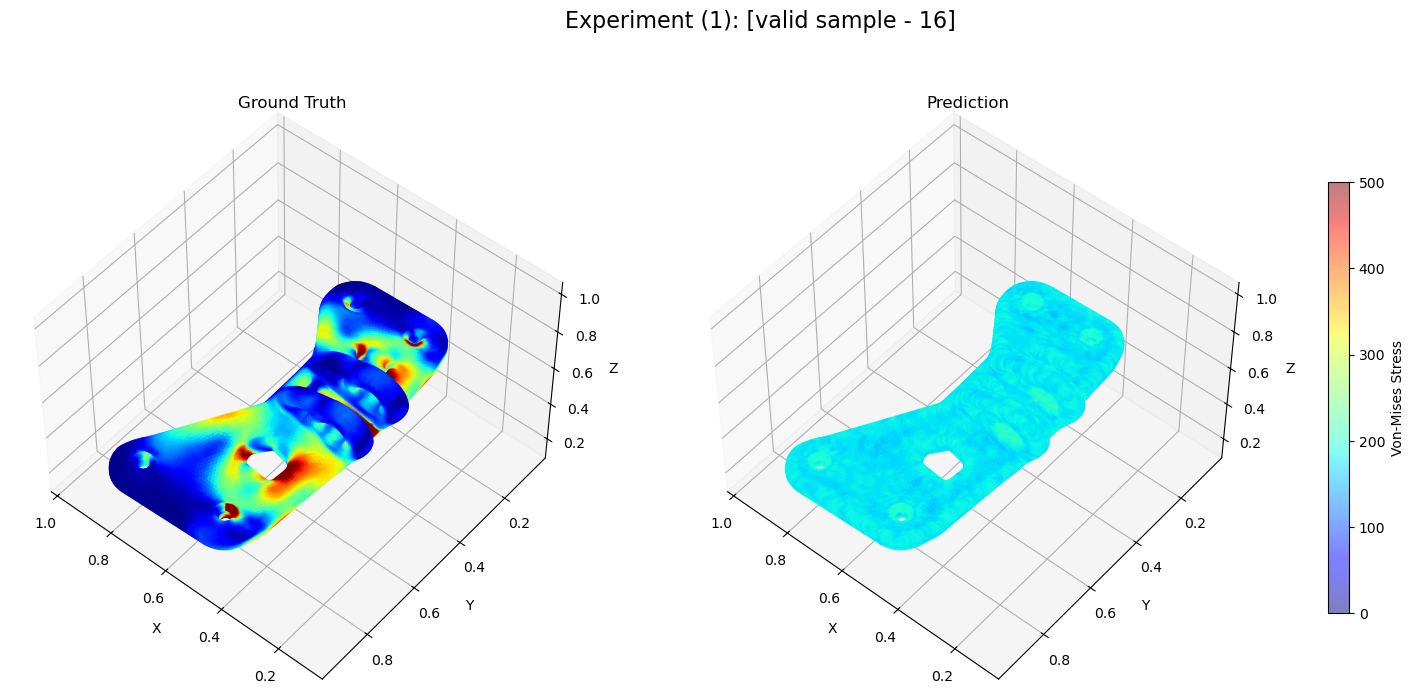

In [5]:

vmin = 0
vmax = 500
cmap = 'jet'

train_sample_id_smallver = [21, 30, 38, 62, 8, 9, 15, 23, 6, 10, 22, 63, 14, 29, 35, 40, 19, 27, 28, 33]
valid_sample_id_smallver = [20, 4, 0, 12, 16]

filename = "./outputs/0417/best_valid_loss.pt"
# filename = "./ckpt/best_valid_loss.pt"
ckpt = torch.load(filename)

trainer.load_model(ckpt = ckpt)

trainer.model.eval()

with torch.no_grad():
    for index, graph in enumerate(trainer.valid_loader):

        if index >= 10:
            break

        graph = graph.to(trainer.device)
        pred = trainer.model(graph)
        y = graph.y
        coords = graph.x[:, :3] # 좌표값 추출

        pred = pred * (trainer.target_std) + trainer.target_mean
        y = y * (trainer.target_std) + trainer.target_mean
        #coords = coords * (trainer.coords_max - trainer.coords_min) + trainer.coords_min

        pred_numpy = pred.to("cpu").detach().numpy()
        y_numpy = y.to("cpu").detach().numpy()
        coords_numpy = coords.to("cpu").detach().numpy()

        print(pred_numpy.shape)
        print(y_numpy.shape)

        # 각 부품별로 x, y, z 축의 최소값과 최대값을 계산
        x_min, x_max = coords_numpy[:, 0].min(), coords_numpy[:, 0].max()
        y_min, y_max = coords_numpy[:, 1].min(), coords_numpy[:, 1].max()
        z_min, z_max = coords_numpy[:, 2].min(), coords_numpy[:, 2].max()

        # 각 축의 중심과 범위를 맞추기 위한 설정
        max_range = np.array([x_max - x_min, y_max - y_min, z_max - z_min]).max() / 2.0

        mid_x = (x_max + x_min) * 0.5
        mid_y = (y_max + y_min) * 0.5
        mid_z = (z_max + z_min) * 0.5

        # 3D 그래프 준비
        fig = plt.figure(figsize=(20, 8))

        # y (Ground Truth) 그래프
        ax_gt = fig.add_subplot(1, 2, 1, projection='3d')
        sc_gt = ax_gt.scatter(coords_numpy[:, 0], coords_numpy[:, 1], coords_numpy[:, 2], c=y_numpy, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
        ax_gt.set_title(f'Ground Truth')

        # 동일한 비율로 축 설정
        ax_gt.set_xlim([mid_x - max_range, mid_x + max_range])
        ax_gt.set_ylim([mid_y - max_range, mid_y + max_range])
        ax_gt.set_zlim([mid_z - max_range, mid_z + max_range])

        ax_gt.set_xlabel('X')
        ax_gt.set_ylabel('Y')
        ax_gt.set_zlabel('Z')
        ax_gt.view_init(elev = 50, azim = 130)

        # pred (Prediction) 그래프
        ax_pred = fig.add_subplot(1, 2, 2, projection='3d')
        sc_pred = ax_pred.scatter(coords_numpy[:, 0], coords_numpy[:, 1], coords_numpy[:, 2], c=pred_numpy, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
        ax_pred.set_title(f'Prediction')

        # 동일한 비율로 축 설정
        ax_pred.set_xlim([mid_x - max_range, mid_x + max_range])
        ax_pred.set_ylim([mid_y - max_range, mid_y + max_range])
        ax_pred.set_zlim([mid_z - max_range, mid_z + max_range])

        ax_pred.set_xlabel('X')
        ax_pred.set_ylabel('Y')
        ax_pred.set_zlabel('Z')
        ax_pred.view_init(elev = 50, azim = 130)

        plt.suptitle(f'Experiment (1): [valid sample - {valid_sample_id_smallver[index]}]', fontsize=16)
        cbar = fig.colorbar(sc_gt, ax=fig.get_axes(), location='right', shrink=0.7, aspect=20, label='Von-Mises Stress')

        plt.show()

Let's now test the rotation function

(57168, 1)
(57168, 1)


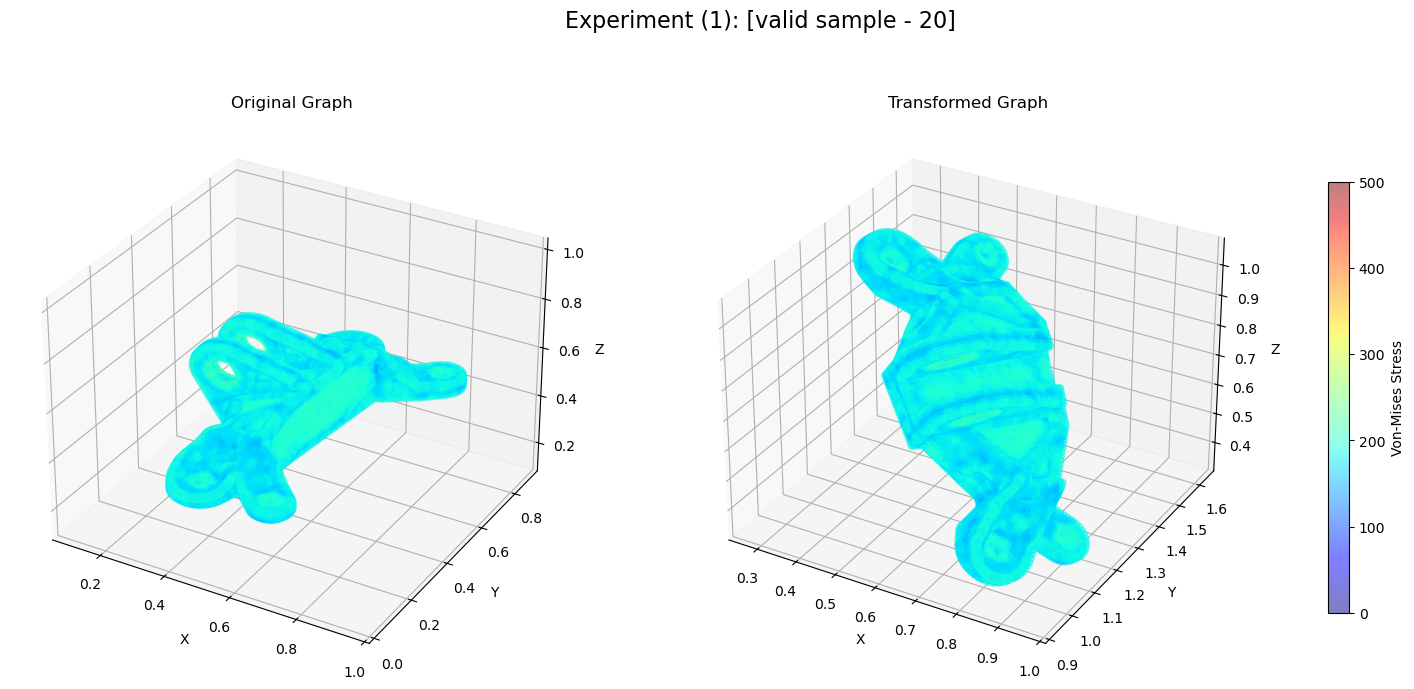

Loss:  tensor(1.5798e-09, device='cuda:2')


In [7]:
from utils import rigid_body_transform_graph

vmin = 0
vmax = 500
cmap = 'jet'

valid_sample_id_smallver = [20, 4, 0, 12, 16]

filename = "./outputs/0417/best_valid_loss.pt"
ckpt = torch.load(filename)

trainer.load_model(ckpt = ckpt)

trainer.model.eval()

with torch.no_grad():
    for index, graph in enumerate(trainer.valid_loader):

        # Just test it on one set
        if index >= 1:
            break 

        graph = graph.to(trainer.device)
        euler_angles = torch.tensor([60, 45, 0]) # ZYX Euler Angles
        euler_angles = euler_angles.to(trainer.device)
        translation = torch.tensor([0.5, 0.2, 0.5])
        translation = translation.to(trainer.device)
        transformed_graph = rigid_body_transform_graph(graph, euler_angles=euler_angles, translation=translation)

        pred_unmodified = trainer.model(graph)
        coords = graph.x[:, :3] # 좌표값 추출
        pred_transformed = trainer.model(transformed_graph)
        transformed_coords = transformed_graph.x[:, :3]
        

        pred_unmodified = pred_unmodified * (trainer.target_std) + trainer.target_mean
        pred_transformed = pred_transformed * (trainer.target_std) + trainer.target_mean
        #coords = coords * (trainer.coords_max - trainer.coords_min) + trainer.coords_min

        pred_unmod_np = pred_unmodified.to("cpu").detach().numpy()
        coords_unmod_np = coords.to("cpu").detach().numpy()
        pred_trans_np = pred_transformed.to("cpu").detach().numpy()
        coords_trans_np = transformed_coords.to("cpu").detach().numpy()

        print(pred_unmod_np.shape)
        print(pred_trans_np.shape)

        # 각 부품별로 x, y, z 축의 최소값과 최대값을 계산
        x_min, x_max = coords_unmod_np[:, 0].min(), coords_unmod_np[:, 0].max()
        y_min, y_max = coords_unmod_np[:, 1].min(), coords_unmod_np[:, 1].max()
        z_min, z_max = coords_unmod_np[:, 2].min(), coords_unmod_np[:, 2].max()

        # 각 축의 중심과 범위를 맞추기 위한 설정
        max_range = np.array([x_max - x_min, y_max - y_min, z_max - z_min]).max() / 2.0

        mid_x = (x_max + x_min) * 0.5
        mid_y = (y_max + y_min) * 0.5
        mid_z = (z_max + z_min) * 0.5

        # 3D 그래프 준비
        fig = plt.figure(figsize=(20, 8))

        # Untransformed 그래프
        ax_gt = fig.add_subplot(1, 2, 1, projection='3d')
        sc_gt = ax_gt.scatter(coords_unmod_np[:, 0], coords_unmod_np[:, 1], coords_unmod_np[:, 2], c=pred_unmod_np, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
        ax_gt.set_title(f'Original Graph')

        # 동일한 비율로 축 설정
        ax_gt.set_xlim([mid_x - max_range, mid_x + max_range])
        ax_gt.set_ylim([mid_y - max_range, mid_y + max_range])
        ax_gt.set_zlim([mid_z - max_range, mid_z + max_range])

        ax_gt.set_xlabel('X')
        ax_gt.set_ylabel('Y')
        ax_gt.set_zlabel('Z')
        ########################################################################

        # 각 부품별로 x, y, z 축의 최소값과 최대값을 계산
        x_min, x_max = coords_trans_np[:, 0].min(), coords_trans_np[:, 0].max()
        y_min, y_max = coords_trans_np[:, 1].min(), coords_trans_np[:, 1].max()
        z_min, z_max = coords_trans_np[:, 2].min(), coords_trans_np[:, 2].max()

        # 각 축의 중심과 범위를 맞추기 위한 설정
        max_range = np.array([x_max - x_min, y_max - y_min, z_max - z_min]).max() / 2.0

        mid_x = (x_max + x_min) * 0.5
        mid_y = (y_max + y_min) * 0.5
        mid_z = (z_max + z_min) * 0.5

        # Transformed 그래프
        ax_pred = fig.add_subplot(1, 2, 2, projection='3d')
        sc_pred = ax_pred.scatter(coords_trans_np[:, 0], coords_trans_np[:, 1], coords_trans_np[:, 2], c=pred_trans_np, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
        ax_pred.set_title(f'Transformed Graph')

        # 동일한 비율로 축 설정
        ax_pred.set_xlim([mid_x - max_range, mid_x + max_range])
        ax_pred.set_ylim([mid_y - max_range, mid_y + max_range])
        ax_pred.set_zlim([mid_z - max_range, mid_z + max_range])

        ax_pred.set_xlabel('X')
        ax_pred.set_ylabel('Y')
        ax_pred.set_zlabel('Z')

        plt.suptitle(f'Experiment (1): [valid sample - {valid_sample_id_smallver[index]}]', fontsize=16)
        cbar = fig.colorbar(sc_gt, ax=fig.get_axes(), location='right', shrink=0.7, aspect=20, label='Von-Mises Stress')

        plt.show()

    loss = torch.nn.MSELoss()
    print("Loss: ", loss(pred_unmodified.squeeze(-1), pred_transformed.squeeze(-1)))

Permutation Invariant

In [7]:
from utils import shuffle_nodes

shuffled_graph = shuffle_nodes(graph)

print("Original graph node features (x):\n", graph.x)
print("Original graph boundary cond (bc):\n", graph.bc)
print("Edge index:\n", graph.edge_index, "\n")

print("Shuffled graph node features (x):\n", shuffled_graph.x)
print("Shuffled graph boundary cond (bc):\n", shuffled_graph.bc)
print("Edge index:\n", shuffled_graph.edge_index, "\n")


Original graph node features (x):
 tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.],
        [10., 10., 10.,  2.,  3.,  4.,  4.,  5.,  6.]], device='cuda:3')
Original graph boundary cond (bc):
 tensor([[0., 0.],
        [1., 0.],
        [0., 1.]], device='cuda:3')
Edge index:
 tensor([[0, 0],
        [1, 2]], device='cuda:3') 

Shuffled graph node features (x):
 tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [10., 10., 10.,  2.,  3.,  4.,  4.,  5.,  6.],
        [ 9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.]], device='cuda:3')
Shuffled graph boundary cond (bc):
 tensor([[0., 0.],
        [0., 1.],
        [1., 0.]], device='cuda:3')
Edge index:
 tensor([[0, 0],
        [2, 1]], device='cuda:3') 



(57168, 1)
(57168, 1)


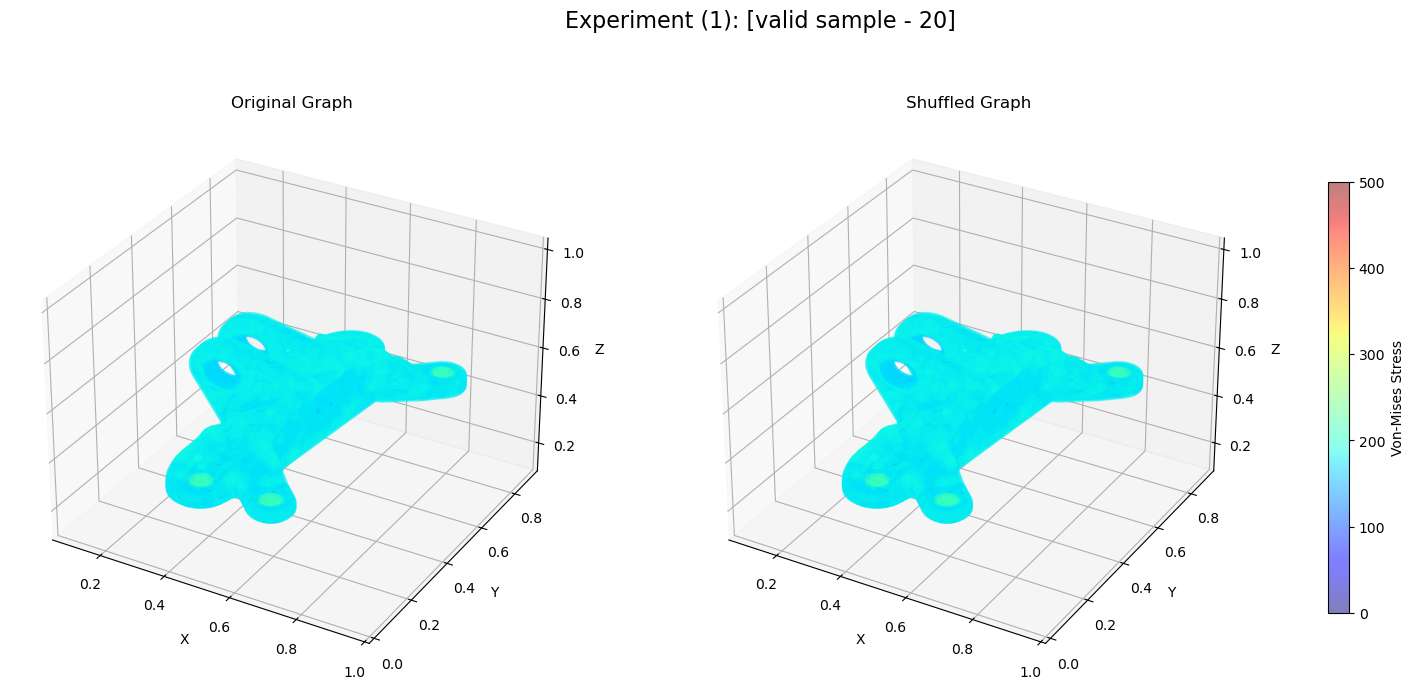

Loss:  tensor(259.5886, device='cuda:3')


In [8]:
vmin = 0
vmax = 500
cmap = 'jet'

valid_sample_id_smallver = [20, 4, 0, 12, 16]

filename = "./ckpt/best_train_loss.pt"
ckpt = torch.load(filename)

trainer.load_model(ckpt = ckpt)

trainer.model.eval()

with torch.no_grad():
    for index, graph in enumerate(trainer.valid_loader):

        # Just test it on one set
        if index >= 1:
            break 

        graph = graph.to(trainer.device)
        shuffled_graph = shuffle_nodes(graph)

        pred_unmodified = trainer.model(graph)
        coords = graph.x[:, :3] # 좌표값 추출
        pred_shuffled = trainer.model(shuffled_graph)
        shuffled_coords = shuffled_graph.x[:, :3]
        

        pred_unmodified = pred_unmodified * (trainer.target_std) + trainer.target_mean
        pred_shuffled = pred_shuffled * (trainer.target_std) + trainer.target_mean
        #coords = coords * (trainer.coords_max - trainer.coords_min) + trainer.coords_min

        pred_unmod_np = pred_unmodified.to("cpu").detach().numpy()
        coords_unmod_np = coords.to("cpu").detach().numpy()
        pred_shuffled_np = pred_shuffled.to("cpu").detach().numpy()
        coords_shuffled_np = shuffled_coords.to("cpu").detach().numpy()

        print(pred_unmod_np.shape)
        print(pred_shuffled_np.shape)

        # 각 부품별로 x, y, z 축의 최소값과 최대값을 계산
        x_min, x_max = coords_unmod_np[:, 0].min(), coords_unmod_np[:, 0].max()
        y_min, y_max = coords_unmod_np[:, 1].min(), coords_unmod_np[:, 1].max()
        z_min, z_max = coords_unmod_np[:, 2].min(), coords_unmod_np[:, 2].max()

        # 각 축의 중심과 범위를 맞추기 위한 설정
        max_range = np.array([x_max - x_min, y_max - y_min, z_max - z_min]).max() / 2.0

        mid_x = (x_max + x_min) * 0.5
        mid_y = (y_max + y_min) * 0.5
        mid_z = (z_max + z_min) * 0.5

        # 3D 그래프 준비
        fig = plt.figure(figsize=(20, 8))

        # Untransformed 그래프
        ax_gt = fig.add_subplot(1, 2, 1, projection='3d')
        sc_gt = ax_gt.scatter(coords_unmod_np[:, 0], coords_unmod_np[:, 1], coords_unmod_np[:, 2], c=pred_unmod_np, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
        ax_gt.set_title(f'Original Graph')

        # 동일한 비율로 축 설정
        ax_gt.set_xlim([mid_x - max_range, mid_x + max_range])
        ax_gt.set_ylim([mid_y - max_range, mid_y + max_range])
        ax_gt.set_zlim([mid_z - max_range, mid_z + max_range])

        ax_gt.set_xlabel('X')
        ax_gt.set_ylabel('Y')
        ax_gt.set_zlabel('Z')
        ########################################################################

        # 각 부품별로 x, y, z 축의 최소값과 최대값을 계산
        x_min, x_max = coords_shuffled_np[:, 0].min(), coords_shuffled_np[:, 0].max()
        y_min, y_max = coords_shuffled_np[:, 1].min(), coords_shuffled_np[:, 1].max()
        z_min, z_max = coords_shuffled_np[:, 2].min(), coords_shuffled_np[:, 2].max()

        # 각 축의 중심과 범위를 맞추기 위한 설정
        max_range = np.array([x_max - x_min, y_max - y_min, z_max - z_min]).max() / 2.0

        mid_x = (x_max + x_min) * 0.5
        mid_y = (y_max + y_min) * 0.5
        mid_z = (z_max + z_min) * 0.5

        # Transformed 그래프
        ax_pred = fig.add_subplot(1, 2, 2, projection='3d')
        sc_pred = ax_pred.scatter(coords_shuffled_np[:, 0], coords_shuffled_np[:, 1], coords_shuffled_np[:, 2], c=pred_shuffled_np, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
        ax_pred.set_title(f'Shuffled Graph')

        # 동일한 비율로 축 설정
        ax_pred.set_xlim([mid_x - max_range, mid_x + max_range])
        ax_pred.set_ylim([mid_y - max_range, mid_y + max_range])
        ax_pred.set_zlim([mid_z - max_range, mid_z + max_range])

        ax_pred.set_xlabel('X')
        ax_pred.set_ylabel('Y')
        ax_pred.set_zlabel('Z')

        plt.suptitle(f'Experiment (1): [valid sample - {valid_sample_id_smallver[index]}]', fontsize=16)
        cbar = fig.colorbar(sc_gt, ax=fig.get_axes(), location='right', shrink=0.7, aspect=20, label='Von-Mises Stress')

        plt.show()

    loss = torch.nn.MSELoss()
    print("Loss: ", loss(pred_unmodified.squeeze(-1), pred_shuffled.squeeze(-1)))